# Combined spectra_example 

# import 

In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lineid_plot
from ramandecompy import spectrafit
from ramandecompy import peakidentify
from ramandecompy import dataprep
from ramandecompy import datavis
from ramandecompy import dataimport
from scipy import interpolate

In [2]:
dataprep.new_hdf5('combined_calibration_dataset')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/water.xlsx', 'water')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx', 'hydrogen')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx', 'methane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx', 'carbon monoxide')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/CO2_100wt%.csv', 'carbon dioxide')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/sapphire.xlsx', 'sapphire')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Propane_test.xlsx', 'Propane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Ethane_test.xlsx', 'Ethane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Acetaldehyde_test.xlsx', 'Acetaldehyde')

Data from ../ramandecompy/tests/test_files/water.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/CO2_100wt%.csv fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/sapphire.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Propane_t

In [3]:
def generate_spectra_dataset(hdf5_filename, target_compound, spectra_count):
    """
    docstring
    """
    hdf5 = h5py.File(hdf5_filename, 'r')
    # get list of compounds from hdf5 file
    compound_list = list(hdf5.keys())
    # create list of interpolated spectra
    interp_list = []
    for compound in compound_list:
        # interpolate
        tuple_list = interp_and_norm(hdf5_filename, compound)
        interp_list.append(tuple_list)
    # identify index of target_compound
    target_index = [i for i, compound in enumerate(compound_list) if target_compound in compound][0]
    # create list of spectra
    x_data = []
    y_data = []
    label = []
    for j in range(spectra_count): 
        # apply scaling to interpolated list
        for i, tuple_list in enumerate(interp_list):
            if i == 0:
                # apply scaling
                scaled_tuple_list = apply_scaling(tuple_list, j, i, target_index)
                summed_tuples = scaled_tuple_list
            else:
                # apply scaling
                scaled_tuple_list = apply_scaling(tuple_list, j, i, target_index)    
                summed_tuples = summed_tuples + scaled_tuple_list
        # sort by wavenumber
        combined = sorted(summed_tuples)
        # add by like
        same_x = {x:0 for x, _ in combined}
        for name, num in combined:
            same_x[name] += num
        sum_combined = list(map(tuple, same_x.items()))
        # unzip
        x_combined, y_combined = zip(*sum_combined)
        # set as arrays
        x_combined = np.asarray(x_combined)
        y_combined = np.asarray(y_combined)
        # plots the spectra, will remove from final rev
        plt.plot(x_combined, y_combined)
        # export data with label (0 = no target, 1 = yes target)
        x_data.append(x_combined)
        y_data.append(y_combined)
        label.append(j % 2)
    hdf5.close()
    return x_data, y_data, label

In [4]:
def interp_and_norm(hdf5_filename, compound):
    """
    docstring
    """
    # open hdf5_file
    hdf5 = h5py.File(hdf5_filename, 'r')
    # interpolate spectra
    x_data = np.asarray(hdf5['{}/wavenumber'.format(compound)])
    y_data = np.asarray(hdf5['{}/counts'.format(compound)])
    interp_spectra = interpolate.interp1d(x_data, y_data, kind='cubic')
    # get integer values across x_range, protecting against edge cases
    x_range = np.arange(int(min(x_data)+1), int(max(x_data)))
    y_interp = interp_spectra(x_range)
    # normalize y_interp values
    y_interp_norm = y_interp/max(y_interp)
    # zip x and y values into tuples
    tuple_list = list(zip(x_range, y_interp_norm))
    # close hdf5 file
    hdf5.close()
    return tuple_list

def apply_scaling(tuple_list, j, i ,target_index):
    """
    docstring
    """
    # unpack tuple_list
    x_data, y_data = zip(*tuple_list)
    y_data = np.asarray(y_data)
    # alternate including target_compound or not
    # if j is odd include target_compound
    if j % 2 == 1:
        if i == target_index:
            y_data_scaled = y_data*np.random.uniform(0.1, 1)
        else:
            y_data_scaled = y_data*np.random.uniform()
    # if j is even no target_compound
    elif j % 2 == 0:
        if i == target_index:
            y_data_scaled = y_data*0
        else:
            y_data_scaled = y_data*np.random.uniform() 
    else:
        pass
    # repack tuple_list
    scaled_tuple_list = list(zip(x_data, y_data_scaled))
    return scaled_tuple_list

In [5]:
def combine_experiment(hdf5_filename, key, x_data, y_data, labels, num):
    """
    This function adds Raman experimental data to an existing hdf5 file. It uses the
    spectrafit.fit_data function to fit the data before saving the fit result and
    the raw data to the hdf5 file. The data_filename must be in a standardized format
    to interact properly with this function. It must take the form anyname_temp_time.xlsx
    (or .csv) since this function will parse the the temp and time from the filename to
    label the data and fit result in the hdf5 file.

    Args:
        hdf5_filename (str): the filename and location of an existing hdf5 file to add the
                             experiment data too.
        data_filename (str): the filename and location of raw Raman spectroscopy data in
                             either the form of an .xlsx or a .csv with the wavenumber data
                             in the 1st column and the counts data in the 2nd column. These
                             files should contain only the wavenumber and counts data
                             (no column labels).

    Returns:
        None
    """
    # handling input errors
    if not isinstance(hdf5_filename, str):
        raise TypeError('Passed value of `hdf5_filename` is not a string! Instead, it is: '
                        + str(type(hdf5_filename)))
    if not hdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError('`hdf5_filename` is not type = .hdf5! Instead, it is: '
                        + hdf5_filename.split('/')[-1].split('.')[-1])
#     if not isinstance(exp_filename, str):
#         raise TypeError('Passed value of `data_filename` is not a string! Instead, it is: '
#                         + str(type(exp_filename)))
#     # confirm exp_filename is correct format (can handle additional decimals in exp_filename
#     label = '.'.join(exp_filename.split('/')[-1].split('.')[:-1])
#     if len(label.split('_')) < 2:
#         raise ValueError("""Passed value of `exp_filename` inapproprate. exp_filename must contain
#         at least one '_', preferably of the format somename_temp_time.xlsx (or .csv)""")
    # r+ is read/write mode and will fail if the file does not exist
    exp_file = h5py.File(hdf5_filename, 'r+')
#     if exp_filename.split('.')[-1] == 'xlsx':
#         data = pd.read_excel(exp_filename, header=None, names=('wavenumber', 'counts'))
#     elif exp_filename.split('.')[-1] == 'csv':
#         data = pd.read_csv(exp_filename, header=None, names=('wavenumber', 'counts'))
#     else:
#         print('data file type not recognized')
    # ensure that the data is listed from smallest wavenumber first
#     if x_data[:1].values > x_data[-1:].values:
#         data = data.iloc[::-1]
#         data.reset_index(inplace=True, drop=True)
#     else:
#         pass
    # peak detection and data fitting
    
    fit_result, residuals = spectrafit.fit_data(x_data[num], y_data[num])
    # write data to .hdf5
    exp_file['{}/{}/wavenumber'.format(key, num)] = x_data[num]
    exp_file['{}/{}/counts'.format(key, num)] = y_data[num]
    exp_file['{}/{}/residuals'.format(key, num)] = residuals
    print('{}/{}/residuals'.format(key, num))
#     fit_result, residuals = spectrafit.fit_data(data['wavenumber'].values, data['counts'].values)
    # extract experimental parameters from filename
#     specs = exp_filename.split('/')[-1].split('.')[:-1]
#     if len(specs) > 1:
#         spec = ''
#         for _, element in enumerate(specs):
#             spec = str(spec+element)
#         specs = spec
#     specs = specs.split('_')
#     time = specs[-1]
#     temp = specs[-2]
    
    for i, result in enumerate(fit_result):
        # create custom datatype
        my_datatype = np.dtype([('fraction', np.float),
                        ('center', np.float),
                        ('sigma', np.float),
                        ('amplitude', np.float),
                        ('fwhm', np.float),
                        ('height', np.float),
                        ('area under the curve', np.float)])
        if i < 9:
            dataset = exp_file.create_dataset('{}/{}/Peak_0{}'.format(key, num, i+1), (1,), dtype=my_datatype)
        else:
            dataset = exp_file.create_dataset('{}/{}/Peak_{}'.format(key, num, i+1), (1,), dtype=my_datatype)
        # apply data to tuple
        data = tuple(result[:7])
        data_array = np.array(data, dtype=my_datatype)
        # write new values to the blank dataset
        dataset[...] = data_array
    print('Data from fit with compound pseudo-Voigt model. Results saved to {}.'.format(hdf5_filename))
    exp_file.close()
    

In [6]:

def keyfinder(hdf5_filename):
    seconds = []
    hdf5 = h5py.File(hdf5_filename, 'r')
    for _, layer_1 in enumerate(list(hdf5.keys())):
        if isinstance(hdf5[layer_1], h5py.Group):
    #         print('\033[1m{}\033[0m'.format(layer_1))
            for _, layer_2 in enumerate(list(hdf5[layer_1].keys())):
                if isinstance(hdf5['{}/{}'.format(layer_1, layer_2)], h5py.Group):
    #                 print('|    \033[1m{}\033[0m'.format(layer_2))
                    seconds.append('{}/{}'.format(layer_1, layer_2))
                    for _, layer_3 in enumerate(list(hdf5['{}/{}'.format(layer_1, layer_2)])):
                        if isinstance(hdf5['{}/{}/{}'.format(layer_1, layer_2, layer_3)],
                                      h5py.Group):
    #                         print('|    |    \033[1m{}\033[0m/...'.format(layer_3))
                            pass
                        else:
                            pass
    #                         print('|    |    {}'.format(layer_3))
                else:
    #                 print('|    {}'.format(layer_2))
                    seconds.append('{}/{}'.format(layer_1, layer_2))
        else:
            pass
    #         print('{}'.format(layer_1))
    hdf5.close()
    return seconds

[[array([0.00027406, 0.00028356, 0.00029646, ..., 0.02219449, 0.02155056,
         0.02093123]),
  array([0.000834  , 0.00085968, 0.00089652, ..., 0.30022403, 0.29150017,
         0.2830351 ]),
  array([0.00025694, 0.00026067, 0.00026468, ..., 0.03266236, 0.03171361,
         0.0307908 ]),
  array([0.00063099, 0.0006446 , 0.00066382, ..., 0.19790652, 0.1921724 ,
         0.18660456]),
  array([0.0001488 , 0.00016562, 0.00019101, ..., 0.00330635, 0.00320724,
         0.00312964]),
  array([0.00077701, 0.0007898 , 0.00080424, ..., 0.03713632, 0.03607341,
         0.03504202]),
  array([0.0004098 , 0.00042943, 0.00045799, ..., 0.14557401, 0.14132891,
         0.13721749]),
  array([0.00033541, 0.0003593 , 0.00039529, ..., 0.03101522, 0.03012568,
         0.02928663]),
  array([0.00056751, 0.00058282, 0.00060307, ..., 0.11456451, 0.11122921,
         0.1079941 ]),
  array([0.00068071, 0.00068743, 0.00069439, ..., 0.04982878, 0.04841861,
         0.0470463 ]),
  array([0.00044906, 0.0004761

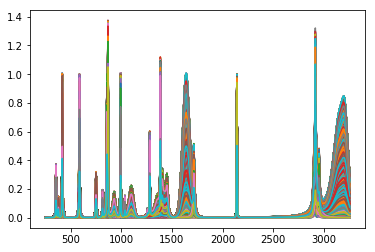

In [7]:
# first a function that will return a normalized interpolated spectra
target_compound = 'water'
# compound = 'water'
hdf5_filename = 'combined_calibration_dataset.hdf5'
spectra_count = 1000
hdf5 = h5py.File(hdf5_filename, 'r')
# get list of compounds from hdf5 file
y_data_list = []
compound_list = list(hdf5.keys())
for target_compound in compound_list:
    x_data, y_data, labels = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
    y_data_list.append(y_data)
len(x_data)
y_data_list

In [8]:
from sklearn.model_selection import train_test_split

# divide and extract test/train and validation data

X_train, X_test, y_train, y_test = train_test_split(y_data, labels, test_size=0.2)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

800 800
200 200


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

# get predictions
Z = logreg.predict(X_test)

logreg.score(X_test, y_test)

1.0

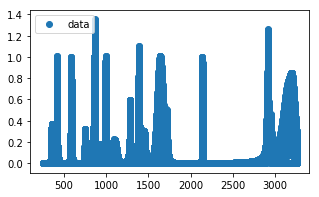

In [ ]:



fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(x_data, y_data, label='data')
# ax.scatter(X_train, y_train, label='train')
# ax.scatter(X_test, y_test, label='teste')
# ax.scatter(X_test, regr.predict(X_test), label='predicted')

# fig, ax = plt.subplots(figsize=(5, 3))
# y = dat['fraction'].values
# x = dat['height'].values
# # Create the linear regression model
# LogRegr = linear_model.LogisticRegression() 
# # plotting the balance
# ax.scatter(dat['height'], dat['fraction'], label = 'balance default',color='r')

# # fit the linear model 
# LogRegr.fit(x.reshape(-1,1),y.reshape(-1,1))
# xres = np.array(x).reshape(-1,1)
# plt.plot(x,LogRegr.predict_proba(xres)[:,1],'o',label = 'fit')
# # Find the coefficients B0 and B1
# print('B0, B1: ',LogRegr.intercept_, LogRegr.coef_[0])
# ax.set_ylabel('Probability Default')
# ax.set_xlabel('Balance')
# ax.set_title('Probability Default vs. Balance')
plt.legend()

In [ ]:
dataprep.new_hdf5('combined_calibration_cal')

In [ ]:
hdf5_calfilename = 'combined_calibration_cal.hdf5' #update to hdf5_calfilename
key = 'cal'
for num, label in enumerate(labels):
    combine_experiment(hdf5_calfilename, key, x_data, y_data, label, num)

cal/0/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/1/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/2/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/3/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/4/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/5/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/6/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.
cal/7/residuals
Data from fit with compound pseudo-Voigt model. Results saved to combined_calibration_cal.hdf5.


In [ ]:
dataprep.view_hdf5(hdf5_calfilename)

In [ ]:
hdf5 = h5py.File(hdf5_calfilename, 'r+')

In [ ]:
key_list = keyfinder(hdf5_calfilename)
key_list

In [ ]:
hdf5_calfilename = 'combined_calibration_dataset.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'combined_calibration_cal.hdf5'
frames = []
for i,key in enumerate(key_list):
    df =peakidentify.peak_assignment(hdf5_expfilename, key, hdf5_calfilename, 50, plot =False)
    frames.append(df)

In [ ]:
result = pd.concat(frames,axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [ ]:
result

In [ ]:
dat = pd.DataFrame()

In [ ]:
dat['fraction']= result[:][0]
dat['sigma']= result[:][1]
# dat['center']= result[:][2]
dat['amplitude']= result[:][3]
dat['fwhm']= result[:][4]
dat['height']= result[:][5]
dat['auc']= result[:][6]
dat['labelencoded']=le.fit_transform(result[:][7])
dat['labels']= result[:][7]
dat['center']= result[:][2]

In [ ]:
# dataprep.view_hdf5('ML_quad_calibration.hdf5')

In [ ]:
# hdf5_filename = 'ML_quad_calibration.hdf5'

In [ ]:
# hdf5 = h5py.File(hdf5_filename, 'r')

In [ ]:
# len(hdf5.keys())

In [ ]:
df.keys()[156:]

In [ ]:
df = pd.read_excel('../ramandecompy/tests/test_files/CalibrationSpectraCombined.xlsx')

In [ ]:
df

In [ ]:
label_list = list(df.keys())[1:]

In [ ]:
label_list 

In [ ]:
dataprep.new_hdf5('combined_calibration_dataset0')

In [ ]:
dataprep.view_hdf5('combined_calibration_dataset0.hdf5')

In [ ]:
# key_list = ['Hydrogen','Sapphire','CarbonDioxide','CarbonMonoxide','Formic Acid','Water','Acetaldehyde','Ethane','Methane','Propane']
# frames = [ combine_spectra(df, key_x, key_y, plot=False)[0] for key_x in key_list for key_y in key_list ]
# columns = [ combine_spectra(df, key_x, key_y, plot=False)[1] for key_x in key_list for key_y in key_list ]

In [ ]:
frames

In [ ]:
columns

In [ ]:
key_list =list(hdf5.keys())
from sklearn import preprocessing
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
encoded_value = le.fit_transform(columns)
print(encoded_value)
print(columns)

In [ ]:
result = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=False,
          keys=columns, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [ ]:
result = result.join(df['Wavelength'])

In [ ]:
result

In [ ]:
result.to_excel("double.xlsx",sheet_name='Sheet_name_1')

In [ ]:
df = pd.read_excel('../examples/double.xlsx')

In [ ]:
# dfquad = pd.read_excel('../examples/quad.xlsx')

In [ ]:
df

In [ ]:
# combine_spectra(df, 'Hydrogen+Hydrogen','Hydrogen+Formic Acid', plot=True)

In [ ]:
# key_list = columns
# frames = [ combine_spectra(df, key_x, key_y, plot=False)[0] for key_x in key_list for key_y in key_list ]
# columns = [ combine_spectra(df, key_x, key_y, plot=False)[1] for key_x in key_list for key_y in key_list ]


In [ ]:
# result

In [ ]:
# columns

In [ ]:
hdf5_calfilename = 'ML_quad_calibration-Copy2.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'ML_quad_calibration-Copy2.hdf5'
frames = []
for _, key in enumerate(key_list):
    df =peakidentify.peak_assignment(hdf5_expfilename, key, hdf5_calfilename, 50, plot =False)
    frames.append(df)

In [ ]:
frames

In [ ]:
df.T

In [ ]:
result = pd.concat(frames,axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [ ]:
result

In [ ]:
# result.to_excel("triple.xlsx",sheet_name='Sheet_name_1')